In [5]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn

## Device

In [6]:
# Set device
cuda = True
DEVICE = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if DEVICE.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (DEVICE)

cuda


## Load data

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
# Load data
url = "https://raw.githubusercontent.com/reisanar/datasets/master/spiral.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,X,Y,Group
0,3.70,18.70,2
1,22.90,19.65,3
2,18.45,11.25,2
3,17.20,11.95,2
4,16.55,3.50,3


In [9]:
# Data shapes
X = df[["X", "X"]].values
y = df["Group"].values
print ("X: ", np.shape(X))
print ("y: ", np.shape(y))

X:  (311, 2)
y:  (311,)


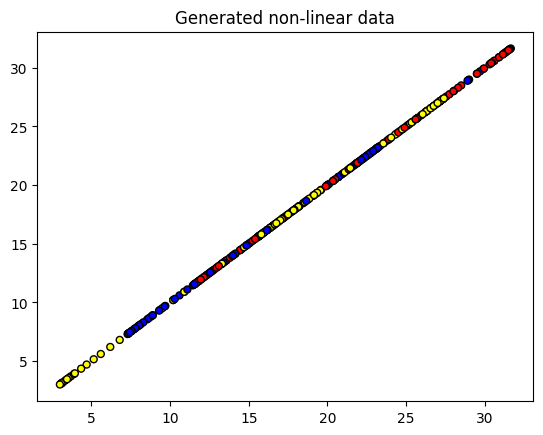

In [10]:
# Visualize data
plt.title("Generated non-linear data")
colors = {1: "red", 2: "yellow", 3: "blue"}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], edgecolors="k", s=25)
plt.show()

## Split data

In [11]:
import collections
from sklearn.model_selection import train_test_split

In [12]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [13]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [14]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (217, 2), y_train: (217,)
X_val: (47, 2), y_val: (47,)
X_test: (47, 2), y_test: (47,)
Sample point: [22.4 22.4] → 3


## Label encoding

In [15]:
import itertools

In [16]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults ;)
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [17]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
label_encoder.class_to_index

{1: 0, 2: 1, 3: 2}

In [18]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: 3
y_train[0]: 2


In [19]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [71 73 73]
weights: {0: 0.014084507042253521, 1: 0.0136986301369863, 2: 0.0136986301369863}


## Standardize data

In [20]:
class StandardScaler(object):
    def __init__(self, mean=None, std=None):
        self.mean = np.array(mean)
        self.std = np.array(std)

    def fit(self, X):
        self.mean =  np.mean(X_train, axis=0)
        self.std = np.std(X_train, axis=0)

    def scale(self, X):
        return (X - self.mean) / self.std

    def unscale(self, X):
        return (X * self.std) + self.mean

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"mean": self.mean.tolist(), "std": self.std.tolist()}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [21]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler()
X_scaler.fit(X_train)

In [22]:
# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.scale(X_train)
X_val = X_scaler.scale(X_val)
X_test = X_scaler.scale(X_test)

In [23]:
# Check (means should be ~0 and std should be ~1)
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_test[0]: mean: 0.1, std: 1.0
X_test[1]: mean: 0.1, std: 1.0


## DataLoader

In [ ]:
import torch

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, y]

    def collate_fn(self, batch):
        """Processing on a batch."""
        # Get inputs
        batch = np.array(batch)
        X = np.stack(batch[:, 0], axis=0)
        y = batch[:, 1]

        # Cast
        X = torch.FloatTensor(X.astype(np.float32))
        y = torch.LongTensor(y.astype(np.int32))

        return X, y

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle, drop_last=drop_last, pin_memory=True)

In [ ]:
# Create datasets
train_dataset = Dataset(X=X_train, y=y_train)
val_dataset = Dataset(X=X_val, y=y_val)
test_dataset = Dataset(X=X_test, y=y_test)
print ("Datasets:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  X: {train_dataset[0][0]}\n"
    f"  y: {train_dataset[0][1]}")

In [ ]:
# Create dataloaders
batch_size = 64
train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)
batch_X, batch_y = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n"
    "Sample point:\n"
    f"  X: {batch_X[0]}\n"
    f"  y: {batch_y[0]}")

## Device

In [ ]:
# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (DEVICE)

## Model

In [ ]:
import math
from torch import nn
import torch.nn.functional as F

In [ ]:
INPUT_DIM = X_train.shape[1] # 2D
HIDDEN_DIM = 100
DROPOUT_P = 0.1
NUM_CLASSES = len(label_encoder.classes)
NUM_EPOCHS = 10

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_p, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs):
        x_in, = inputs
        z = F.relu(self.fc1(x_in))
        z = self.dropout(z)
        z = self.fc2(z)
        return z

In [ ]:
# Initialize model
model = MLP(
    input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM,
    dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
model = model.to(DEVICE) # set device
print (model.named_parameters)

## Trainer

In [ ]:
def train_step(self, dataloader):
    """Train step."""
    # Set model to train mode
    self.model.train()
    loss = 0.0

    # Iterate over train batches
    for i, batch in enumerate(dataloader):

        # Step
        batch = [item.to(self.device) for item in batch]  # Set device
        inputs, targets = batch[:-1], batch[-1]
        self.optimizer.zero_grad()  # Reset gradients
        z = self.model(inputs)  # Forward pass
        J = self.loss_fn(z, targets)  # Define loss
        J.backward()  # Backward pass
        self.optimizer.step()  # Update weights

        # Cumulative Metrics
        loss += (J.detach().item() - loss) / (i + 1)

    return loss

In [ ]:
def eval_step(self, dataloader):
    """Validation or test step."""
    # Set model to eval mode
    self.model.eval()
    loss = 0.0
    y_trues, y_probs = [], []

    # Iterate over val batches
    with torch.inference_mode():
        for i, batch in enumerate(dataloader):

            # Step
            batch = [item.to(self.device) for item in batch]  # Set device
            inputs, y_true = batch[:-1], batch[-1]
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, y_true).item()

            # Cumulative Metrics
            loss += (J - loss) / (i + 1)

            # Store outputs
            y_prob = F.softmax(z).cpu().numpy()
            y_probs.extend(y_prob)
            y_trues.extend(y_true.cpu().numpy())

    return loss, np.vstack(y_trues), np.vstack(y_probs)

In [ ]:
def predict_step(self, dataloader):
    """Prediction step."""
    # Set model to eval mode
    self.model.eval()
    y_probs = []

    # Iterate over val batches
    with torch.inference_mode():
        for i, batch in enumerate(dataloader):

            # Forward pass w/ inputs
            inputs, targets = batch[:-1], batch[-1]
            z = self.model(inputs)

            # Store outputs
            y_prob = F.softmax(z).cpu().numpy()
            y_probs.extend(y_prob)

    return np.vstack(y_probs)

## LR scheduler

In [ ]:
""" 
# Initialize the LR scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3)
...
train_loop():
    ...
    # Steps
    train_loss = trainer.train_step(dataloader=train_dataloader)
    val_loss, _, _ = trainer.eval_step(dataloader=val_dataloader)
    self.scheduler.step(val_loss)
    ... 
"""

## Early stopping

In [ ]:
""" 
# Early stopping
if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model = trainer.model
    _patience = patience  # reset _patience
else:
    _patience -= 1
if not _patience:  # 0
    print("Stopping early!")
    break "
"""

## Training

In [ ]:
from torch.optim import Adam

In [ ]:
LEARNING_RATE = 1e-2
NUM_EPOCHS = 100
PATIENCE = 3

In [ ]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [ ]:
# Define optimizer & scheduler
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3)

In [ ]:
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None):

        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0

        # Iterate over train batches
        for i, batch in enumerate(dataloader):

            # Step
            batch = [item.to(self.device) for item in batch]  # Set device
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimizer.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)

        return loss

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss_fn(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)

                # Store outputs
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_probs = []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Forward pass w/ inputs
                inputs, targets = batch[:-1], batch[-1]
                z = self.model(inputs)

                # Store outputs
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)

        return np.vstack(y_probs)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            # Steps
            train_loss = self.train_step(dataloader=train_dataloader)
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            # Logging
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}, "
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )
        return best_model

In [ ]:
# Trainer module
trainer = Trainer(
    model=model, device=DEVICE, loss_fn=loss_fn,
    optimizer=optimizer, scheduler=scheduler)

In [ ]:
# Train
best_model = trainer.train(
    NUM_EPOCHS, PATIENCE, train_dataloader, val_dataloader)

## Evaluation

In [ ]:
import json
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

In [ ]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

In [ ]:
# Determine performance
performance = get_metrics(
    y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))

## Saving & loading

In [ ]:
from pathlib import Path

In [ ]:
# Save artifacts
dir = Path("mlp")
dir.mkdir(parents=True, exist_ok=True)
label_encoder.save(fp=Path(dir, "label_encoder.json"))
X_scaler.save(fp=Path(dir, "X_scaler.json"))
torch.save(best_model.state_dict(), Path(dir, "model.pt"))
with open(Path(dir, 'performance.json'), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

In [ ]:
# Load artifacts
device = torch.device("cpu")
label_encoder = LabelEncoder.load(fp=Path(dir, "label_encoder.json"))
X_scaler = StandardScaler.load(fp=Path(dir, "X_scaler.json"))
model = MLP(
    input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM,
    dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(Path(dir, "model.pt"), map_location=device))
model.to(device)

In [ ]:
# Initialize trainer
trainer = Trainer(model=model, device=device)

In [ ]:
# Dataloader
sample = [[0.106737, 0.114197]] # c1
X = X_scaler.scale(sample)
y_filler = label_encoder.encode([label_encoder.classes[0]]*len(X))
dataset = Dataset(X=X, y=y_filler)
dataloader = dataset.create_dataloader(batch_size=batch_size)

In [ ]:
# Inference
y_prob = trainer.predict_step(dataloader)
y_pred = np.argmax(y_prob, axis=1)
label_encoder.decode(y_pred)